In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as ss

In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', None)

In [3]:
# #get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Sound check

In [4]:
# sound check
# do a quick check for sound
sound = pd.read_csv('pilot_2/data_exp_24005-v8_task-qgn4.csv', sep = ",")
sound = sound.replace('null', np.nan)
sound = sound.replace('nan', np.nan)

In [5]:
sound = sound[np.isfinite(sound['button pressed'])]

In [6]:
correct = [1, 0, 0]* 30

In [7]:
s = (sound['button pressed'] == correct).reset_index(name = 'check')
sound = sound.reset_index()
sound = pd.merge(s[['index', 'check']], sound, on = 'index')
sound_final= sound[['Participant Private ID','button pressed','check']]

In [8]:
# 1912551

In [9]:

# sound_final.head(300)

In [10]:
# import file
data_1 = pd.read_csv("pilot_2/data_exp_24005-v8_task-t2w7.csv", sep = ",")
data_2 = pd.read_csv("pilot_2/data_exp_24005-v8_task-lhx6.csv", sep = ",")


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
data_2.drop(['Unnamed: 37', 'Unnamed: 39'], axis = 1, inplace = True)


In [12]:
data = pd.concat([data_1, data_2])

In [13]:
data = data.replace('null', np.nan)
data  = data.replace('nan', np.nan)


In [14]:
data['start_time'] = round(data['start_time'].astype(float))

In [15]:
data.columns

Index(['Event Index', 'UTC Timestamp', 'UTC Date', 'Local Timestamp',
       'Local Timezone', 'Local Date', 'Experiment ID', 'Experiment Version',
       'Tree Node Key', 'Repeat Key', 'Schedule ID', 'Participant Public ID',
       'Participant Private ID', 'Participant Starting Group',
       'Participant Status', 'Participant Completion Code',
       'Participant External Session ID', 'Participant Device Type',
       'Participant Device', 'Participant OS', 'Participant Browser',
       'Participant Monitor Size', 'Participant Viewport Size', 'Checkpoint',
       'Task Name', 'Task Version', 'randomiser-cdvn', 'reaction time',
       'key pressed', 'price_displayed', 'environment', 'task', 'function id',
       'builtin rt', 'end_time', 'start_time', 'response', 'round_instance'],
      dtype='object')

In [16]:
data = data[['Participant Private ID', 'UTC Timestamp','key pressed', 'price_displayed', 'environment', 'task', 'function id',
       'builtin rt', 'end_time', 'start_time', 'response', 'round_instance']]


In [17]:
data.rename(columns={"Participant Private ID": "Subject"}, inplace = True)


In [18]:
data = data.sort_values(by = ['Subject', 'start_time'])

In [19]:
data['trial_label'] = data[['environment', 'round_instance']].apply(lambda x: ' '.join(x.astype(str)), axis=1)


In [20]:
# exclude
data = data[data.Subject != 1912551]

In [21]:
fish = data[(data.task == "fishing_pos")|(data.task == "fishing_neg")]


In [22]:
fish = fish[fish['start_time'].notna()]

In [23]:
fish['start_time'] = fish['start_time'].astype(int)

In [24]:
fish.environment.unique()

array(['pre_mood', 'post_mood'], dtype=object)

In [25]:
fish["environment_binary"] = np.where(fish["environment"] == 'pre_mood', 0, 1)


In [26]:
d = fish.groupby(['Subject','environment_binary', 'round_instance'])['start_time'].diff().shift(-1).reset_index(name = 'latency')
d = d.set_index('index')


In [27]:
fish['latency'] = d['latency']
fish = fish.sort_index().sort_values(['Subject', 'start_time'])

In [139]:
fish.head(1)

Subject     UTC Timestamp  key pressed  price_displayed environment  \
5 1912522.000 1599014941067.000       40.000            6.000    pre_mood   

          task  function id  builtin rt          end_time     start_time  \
5  fishing_pos  fishing_pos      38.425 1599014940733.000  1599014940693   

   response  round_instance   trial_label  environment_binary  latency mood  
5       nan           1.000  pre_mood 1.0                   0  142.000  NaN

In [29]:
def mask_first(x):
    """
    get rid of the first spike by creating a mask of 0, 1, 1, 1, ...
    """
    result = np.ones_like(x)
    result[0] = 0
    return result

In [30]:
mask = fish.groupby(['Subject', 'environment'])['round_instance'].transform(mask_first).astype(bool)

# data_useful = data_useful.loc[mask]


In [31]:
fish = fish.loc[mask]

In [32]:
fish.head()
fish["mood"] = fish["task"].map({'fishing_pos': "pos", 'fishing_neg':'neg'})


In [33]:
fish.groupby("mood")["Subject"].nunique()

mood
neg    16
pos    13
Name: Subject, dtype: int64

In [140]:
fish["mood"] = fish["function id"].map({"fishing_pos":"pos",
                                    "fishing_neg":"neg"})

# graph

In [39]:
mood_graph_pre = fish[(fish.environment == "pre_mood")]
anova = mood_graph_pre.groupby(["Subject", "mood"])['latency'].mean().reset_index(name = "latency")


In [40]:
ss.f_oneway(anova["latency"][anova["mood"] == "neg"],
           anova["latency"][anova["mood"] == "pos"])

F_onewayResult(statistic=3.7988360284443723, pvalue=0.061747948169746145)

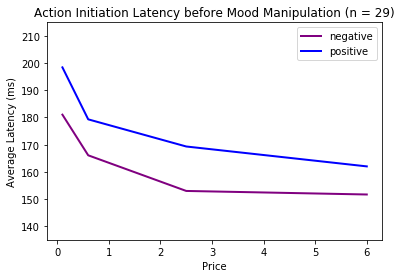

In [229]:
mood_graph_pre = fish[(fish.environment == "pre_mood")]
p = mood_graph_pre.groupby(["environment","mood","price_displayed"])['latency'].mean().reset_index(name = "latency")
price = [0.1, 0.6, 2.5, 6.0]
latency_pre_p = p.latency[(p.mood == 'pos')]
latency_pre_n = p.latency[(p.mood == 'neg')]
plt.plot( price, latency_pre_n, marker='', color='purple', linewidth=2, label = "negative")
plt.plot( price, latency_pre_p, marker='', color='blue', linewidth=2, label = "positive")
# plt.plot( price, latency_n_pre, marker='', color='black', linewidth=2, linestyle='dashed', label="negative")
plt.title("Action Initiation Latency before Mood Manipulation (n = 29)")
plt.xlabel("Price")
plt.ylabel("Average Latency (ms)")
plt.ylim([135, 215])
plt.legend()
plt.savefig('price_latency_before_mood.png', transparent=True, dpi=300)


In [41]:
# mood graph
mood_graph = fish[(fish.environment == "post_mood")]
g = mood_graph.groupby(["environment","mood","price_displayed"])['latency'].mean().reset_index()


In [42]:
g

environment mood  price_displayed  latency
0   post_mood  neg            0.100  162.136
1   post_mood  neg            0.600  157.478
2   post_mood  neg            2.500  166.825
3   post_mood  neg            6.000  168.845
4   post_mood  pos            0.100  176.593
5   post_mood  pos            0.600  172.066
6   post_mood  pos            2.500  171.333
7   post_mood  pos            6.000  175.549

In [43]:
price = [0.1, 0.6,2.5, 6.0]
latency_p = g.latency[(g.mood == 'pos')]
latency_n = g.latency[(g.mood == 'neg')]

In [44]:
data.Subject.nunique()

29

In [45]:
mood_graph.head(1)

Subject     UTC Timestamp  key pressed  price_displayed environment  \
843 1912522.000 1599015117611.000       40.000            6.000   post_mood   

            task  function id  builtin rt          end_time     start_time  \
843  fishing_pos  fishing_pos      62.055 1599015117300.000  1599015117238   

     response  round_instance    trial_label  environment_binary  latency mood  
843       nan           1.000  post_mood 1.0                   1  168.000  pos

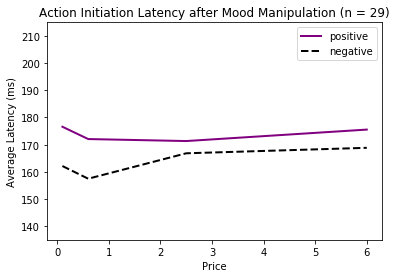

In [47]:
plt.plot( price, latency_p, marker='', color='purple', linewidth=2, label = "positive")
plt.plot( price, latency_n, marker='', color='black', linewidth=2, linestyle='dashed', label="negative")
plt.title("Action Initiation Latency after Mood Manipulation (n = 29)")
plt.xlabel("Price")
plt.ylabel("Average Latency (ms)")
plt.legend()
plt.ylim([135, 215])
plt.savefig('price_latency_after_mood.png', transparent=True, dpi=300)


In [210]:
# response
rating = data[(data.task == "mood_rating_pos")|(data.task == "mood_rating_neg")]


In [211]:

rating = rating[rating['response'].notna()]

In [212]:
rating["response"].describe()

count   174.000
mean     68.983
std      24.414
min      17.000
25%      50.250
50%      72.000
75%      91.750
max     100.000
Name: response, dtype: float64

In [213]:
6 * 30

180

In [214]:
rating = rating.sort_values(["Subject", "UTC Timestamp"])

In [215]:
rating["index"]=[1]*len(rating)


In [216]:
i = rating.groupby(["Subject", "environment"])["index"].cumsum().reset_index(name = "index")
rating = pd.merge(rating, i, left_on=rating.index, right_on = "level_0", how = "inner")
rating.head()

Subject     UTC Timestamp  key pressed  price_displayed environment  \
0 1912522.000 1599014983990.000          nan              nan    pre_mood   
1 1912522.000 1599015030686.000          nan              nan    pre_mood   
2 1912522.000 1599015075027.000          nan              nan    pre_mood   
3 1912522.000 1599015159134.000          nan              nan   post_mood   
4 1912522.000 1599015204743.000          nan              nan   post_mood   

              task      function id  builtin rt  end_time  start_time  \
0  mood_rating_pos  mood_rating_pos         nan       nan         nan   
1  mood_rating_pos  mood_rating_pos         nan       nan         nan   
2  mood_rating_pos  mood_rating_pos         nan       nan         nan   
3  mood_rating_pos  mood_rating_pos         nan       nan         nan   
4  mood_rating_pos  mood_rating_pos         nan       nan         nan   

   response  round_instance    trial_label  index_x  level_0  index_y  
0    76.000           4.000   pre_mood 4.0        1      264        1  
1    84.000           8.000   pre_mood 8.0        1      537        2  
2    83.000          12.000  pre_mood 12.0        1      830        3  
3    91.000           4.000  post_mood 4.0        1     1110        1  
4    88.000           8.000  post_mood 8.0        1     1384        2

In [217]:
rating.drop(["index_x", "level_0"], axis = 1, inplace = True)

In [218]:
rating["mood"] = rating["task"].map({"mood_rating_pos":"pos",
                                    "mood_rating_neg":"neg"})

In [219]:
rating["name"] = rating["Subject"].astype(int).astype(str) + " " + rating["mood"]


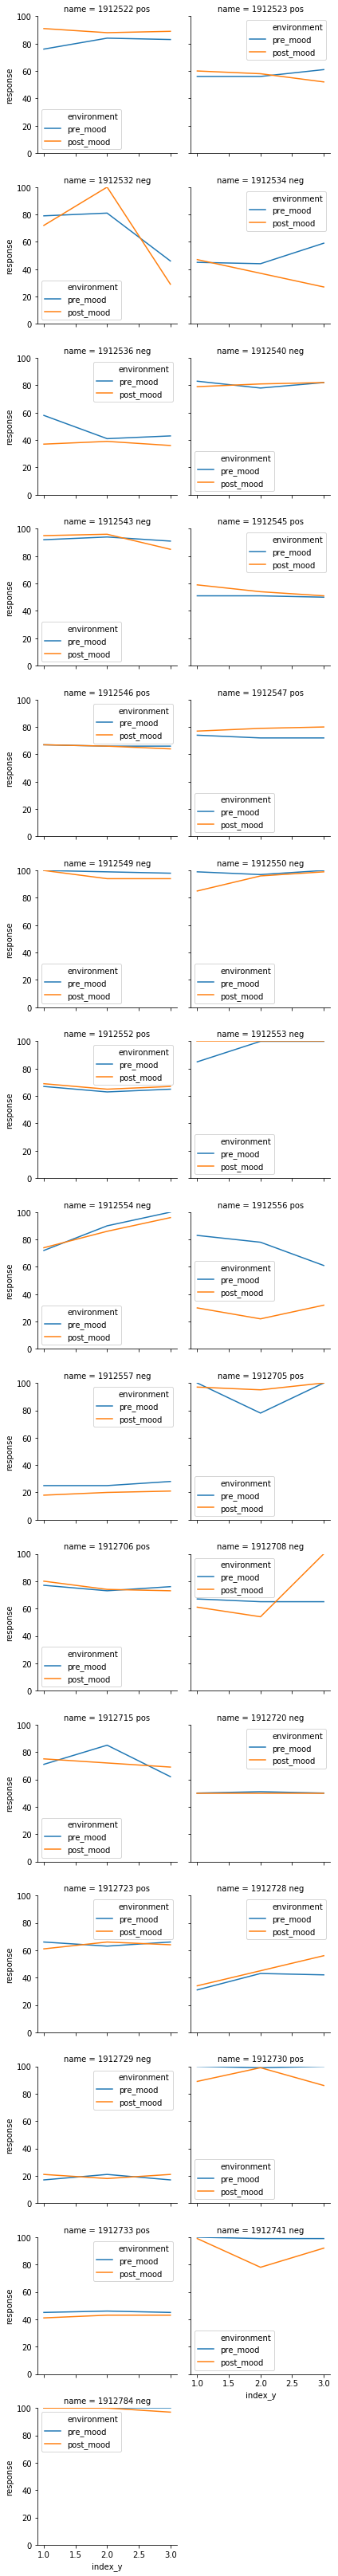

In [220]:
r = sns.FacetGrid(rating, col="name", col_wrap=2, height=3, ylim=(0, 100))
r.map(sns.lineplot, "index_y", "response", "environment", markers=True)
for ax in r.axes.ravel():
    ax.legend()

plt.savefig("rating_by_subject.png", transparent=True, dpi=300)
# g = sns.FacetGrid(plot, col="id", col_wrap=4, height=2, ylim=(50, 300))
# g.map(sns.lineplot,'price_displayed','average_latency', 'environment', palette = "GnBu_d", legend = 'full',
#       err_style="bars")



In [225]:
fish[fish.Subject == 1912556].groupby(["environment", "price_displayed"])["latency"].mean()

environment  price_displayed
post_mood    0.100             152.791
             0.600             162.563
             2.500             161.043
             6.000             165.772
pre_mood     0.100             187.026
             0.600             168.972
             2.500             157.984
             6.000             153.539
Name: latency, dtype: float64

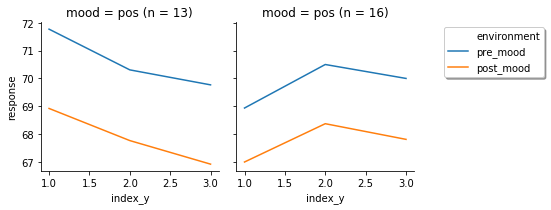

In [249]:
b = sns.FacetGrid(rating, col="mood", col_order=["pos", "neg"])
b = b.map(sns.lineplot, "index_y", "response","environment", markers=True, ci = None)
plt.legend(loc='upper center', bbox_to_anchor=(1.45, 1), shadow=True)
axes = b.axes.flatten()
axes[0].set_title("mood = pos (n = 13)")
axes[1].set_title("mood = pos (n = 16)")
    
plt.savefig("average_rating_29.png", transparent = True, dpi = 300, bbox_inches='tight')

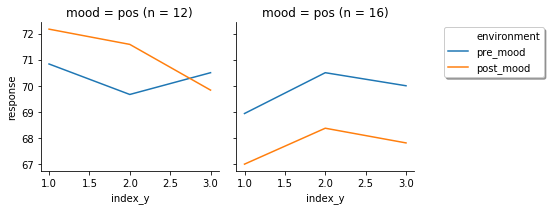

In [250]:
b = sns.FacetGrid(rating[rating.Subject != 1912556], col="mood", col_order=["pos", "neg"])
b = b.map(sns.lineplot, "index_y", "response","environment", markers=True, ci = None)
plt.legend(loc='upper center', bbox_to_anchor=(1.45, 1), shadow=True)
axes = b.axes.flatten()
axes[0].set_title("mood = pos (n = 12)")
axes[1].set_title("mood = pos (n = 16)")
    
plt.savefig("average_rating_28.png", transparent = True, dpi = 300, bbox_inches='tight')


# Look at neg and pos seperately?

In [86]:
fish.head()

Subject     UTC Timestamp  key pressed  price_displayed environment  \
5 1912522.000 1599014941067.000       40.000            6.000    pre_mood   
6 1912522.000 1599014941301.000       40.000            6.000    pre_mood   
7 1912522.000 1599014941301.000       40.000            6.000    pre_mood   
8 1912522.000 1599014941551.000       40.000            6.000    pre_mood   
9 1912522.000 1599014941817.000       40.000            6.000    pre_mood   

          task  function id  builtin rt          end_time     start_time  \
5  fishing_pos  fishing_pos      38.425 1599014940733.000  1599014940693   
6  fishing_pos  fishing_pos      48.905 1599014940884.000  1599014940835   
7  fishing_pos  fishing_pos      48.645 1599014941038.000  1599014940989   
8  fishing_pos  fishing_pos      31.940 1599014941180.000  1599014941147   
9  fishing_pos  fishing_pos      29.325 1599014941325.000  1599014941295   

   response  round_instance   trial_label  environment_binary  latency mood  
5       nan           1.000  pre_mood 1.0                   0  142.000  pos  
6       nan           1.000  pre_mood 1.0                   0  154.000  pos  
7       nan           1.000  pre_mood 1.0                   0  158.000  pos  
8       nan           1.000  pre_mood 1.0                   0  148.000  pos  
9       nan           1.000  pre_mood 1.0                   0  145.000  pos

In [1]:
b = sns.FacetGrid(fish, col="mood", col_order=["pos", "neg"])
b = b.map(sns.lineplot, "price_displayed", "latency", "environment",
         err_style = "bars")
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 0.9), shadow=True)
plt.ylabel("latency (ms)")
plt.savefig("average_latency_pos_neg.png", transparent = True, dpi = 300, 
            bbox_inches='tight')
plt.show()

NameError: name 'sns' is not defined

# by subject plot

In [254]:
fish.head(1)
fish["title"] = fish["Subject"].astype(str) + " " + fish["mood"]

In [256]:
f = fish.groupby(["title", "environment", "price_displayed"])["latency"].mean().reset_index(name = "avg")

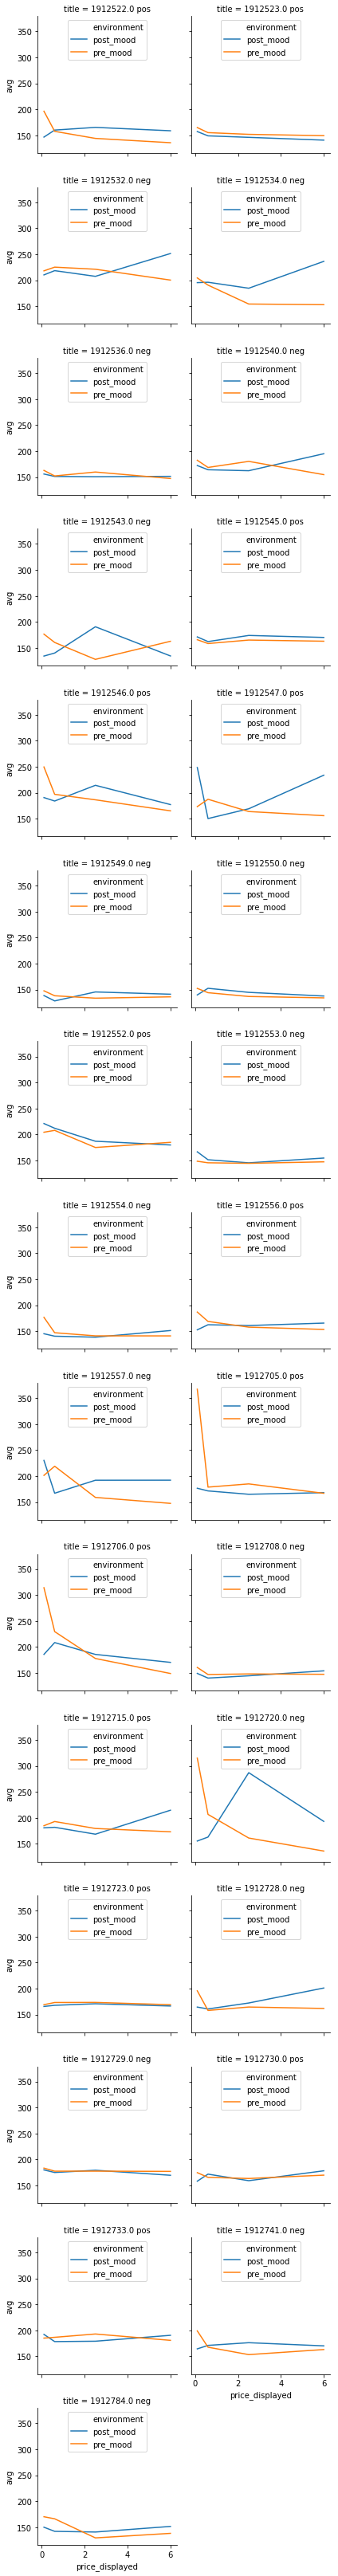

In [264]:
r = sns.FacetGrid(f, col="title", col_wrap=2, height=3)
r.map(sns.lineplot, "price_displayed", "avg", "environment", markers=True)
for ax in r.axes.ravel():
    ax.legend(loc='upper center')
# plt.legend(loc='upper center', bbox_to_anchor=(1.2, 0.9), shadow=True)
plt.savefig("latency_by_subject.png", transparent=True, dpi=300, bbox_inches='tight')
plt.show()

# median latency between high and low

In [141]:
fish.Subject.nunique()

29

In [142]:
m = fish.groupby(["Subject", "price_displayed"])["latency"].median().reset_index(name = "median")

In [143]:
m = m[m.price_displayed.isin([0.1, 6])]

In [144]:
diff = m.groupby(["Subject"], as_index = True)["median"].diff().shift(-1)

In [145]:
m["diff"] = diff

In [146]:
m = m.dropna()

In [147]:
np.median(m["diff"]*(-1))

12.0

In [148]:
# only pre-mood

In [149]:
m_pre_mood = fish[fish.environment == "pre_mood"]

In [150]:
m_pre_mood = m_pre_mood.groupby(["Subject", "price_displayed"])["latency"].median().reset_index(name = "median")

In [151]:
m_pre_mood = m_pre_mood[m_pre_mood.price_displayed.isin([0.1, 6])]

In [152]:
diff_pre_mood = m_pre_mood.groupby(["Subject"], as_index = True)["median"].diff().shift(-1)

In [153]:
m_pre_mood["diff"] = diff_pre_mood

In [154]:
m_pre_mood = m_pre_mood.dropna()

In [155]:
np.median(m_pre_mood["diff"]*(-1))

22.0

In [126]:
f_1 = fish[fish.trial_label.isin(['pre_mood 1.0',
                                 'pre_mood 2.0',
                                 'pre_mood 3.0',
                                 'pre_mood 4.0'])]



In [127]:
f_2 = fish[fish.trial_label.isin(['pre_mood 5.0',
                                 'pre_mood 6.0',
                                 'pre_mood 7.0',
                                 'pre_mood 8.0'])]

In [128]:
m_pre_mood_1 = f_1.groupby(["Subject", "price_displayed"])["latency"].median().reset_index(name = "median")
m_pre_mood_1 = m_pre_mood_1[m_pre_mood_1.price_displayed.isin([0.1, 6])]
diff_pre_mood_1 = m_pre_mood_1.groupby(["Subject"], as_index = True)["median"].diff().shift(-1)
m_pre_mood_1["diff"] = diff_pre_mood_1
m_pre_mood_1 = m_pre_mood_1.dropna()
np.median(m_pre_mood_1["diff"]*(-1))


9.0

In [129]:
m_pre_mood_2 = f_2.groupby(["Subject", "price_displayed"])["latency"].median().reset_index(name = "median")
m_pre_mood_2 = m_pre_mood_2[m_pre_mood_2.price_displayed.isin([0.1, 6])]
diff_pre_mood_2 = m_pre_mood_2.groupby(["Subject"], as_index = True)["median"].diff().shift(-1)
m_pre_mood_2["diff"] = diff_pre_mood_2
m_pre_mood_2 = m_pre_mood_2.dropna()
np.median(m_pre_mood_2["diff"]*(-1))


27.5

In [130]:
from scipy import stats as ss

In [131]:
ss.ttest_rel(m_pre_mood_2["diff"], m_pre_mood_1["diff"])

Ttest_relResult(statistic=0.5036211665131262, pvalue=0.6184670833033181)

In [132]:
# post-mood overall

In [200]:
m_post_mood = fish[fish.environment == "post_mood"]

In [201]:
m_post_mood = m_post_mood.groupby(["Subject","price_displayed"])["latency"].median().reset_index(name = "median")
m_post_mood = m_post_mood[m_post_mood.price_displayed.isin([0.1, 6])]
diff_post_mood = m_post_mood.groupby(["Subject"], as_index = True)["median"].diff().shift(-1)
m_post_mood["diff"] = diff_post_mood
m_post_mood = m_post_mood.dropna()
np.median(m_post_mood["diff"]*(-1))

1.0

In [182]:
# post-mood positive

In [193]:
m_pos = fish[(fish.mood == "pos")&(fish.environment == "post_mood")]

In [194]:
m_pos = m_pos.groupby(["Subject", "price_displayed"])["latency"].median().reset_index(name = "median")

In [195]:
m_pos= m_pos[m_pos.price_displayed.isin([0.1, 6])]

In [196]:
diff_pos_mood = m_pos.groupby(["Subject"], as_index = True)["median"].diff().shift(-1)

In [197]:
m_pos["diff"] = diff_pos_mood

In [198]:
m_pos = m_pos.dropna()

In [199]:
np.median(m_pos ["diff"]*(-1))

1.0

In [202]:
m_post_mood = fish[fish.environment == "post_mood"]

In [203]:
m_neg = m_post_mood[m_post_mood.mood == "neg"]

In [204]:
m_neg = m_neg.groupby(["Subject", "price_displayed"])["latency"].median().reset_index(name = "median")

In [205]:
m_neg= m_neg[m_neg.price_displayed.isin([0.1, 6])]

In [206]:
diff_neg_mood = m_neg.groupby(["Subject"], as_index = True)["median"].diff().shift(-1)

In [207]:
m_neg["diff"] = diff_neg_mood

In [208]:
m_neg = m_neg.dropna()

In [209]:
np.median(m_neg ["diff"]*(-1))

0.5

For example, if there is any order effect in the range in your young online data, 
then best to put the median range not only for low and high blocks 
but also for first and second blocks. 

These are all super simple analyses. Obviously, you don't want to put 10 pages of analyses, 

but if there is a big order effect (bigger range in first block) then its obviously relevant to this discussion.

In [251]:
fish.to_csv("for_ritwik_fish_latency.csv")

In [252]:
rating.to_csv("for_ritwik_rating.csv")